In [1]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf

## Classes and methods for GridPoint-manipulation

In [2]:
class GridPoint():
    def __init__(self, pid: int, x: float, y: float, score: float = 0):
        self._pid = pid
        self._x = x
        self._y = y
        self._score = score
        self._neighbours = []

    def get_coordinates(self):
        return (self._x, self._y)

    @property
    def neighbours(self):
        return self._neighbours

    @neighbours.setter
    def neighbours(self, neighbours: list):
        # print(f"set grid point ({self._x}, {self._y}) neigbours to: {neighbours}")
        self._neighbours = neighbours

    @property
    def x(self):
        return self._x
    
    @property
    def y(self):
        return self._y

    @property
    def pid(self):
        return self._pid

    @property
    def score(self):
        return self._score

    @score.setter
    def score(self, score):
        #print(f"set grid point ({round(self._x, 3)}, {round(self._y, 3)}) to score: {round(score, 3)}")
        self._score = score

    def __repr__(self):
        # return (f"{self._pid}")
        return (f"({round(self._x, 3)}, {round(self._y, 3)}, {self._score})")



def generate_point_grid(grid_resolution=20):
    VAL_RANGE = 2.86
    # 1. Generates a point grid G of resolution N_g = n_g x n_g within a bounding box of size ~[-1.2, 1.2].
    #    Grid size 20 x 20 deemed adequate in papag. et al. We add padding to help neighbour generation
    
    # Create list of coordinates from 0->VAL_RANGE, then shift it to be mirrored on 0.
    # Grid resolution + 2 for padding
    x_coordinates = np.linspace(0.0, VAL_RANGE, num=grid_resolution+2, endpoint=True) - VAL_RANGE/2
    y_coordinates = np.linspace(0.0, VAL_RANGE, num=grid_resolution+2, endpoint=True) - VAL_RANGE/2
    
    point_grid = []
    point_id = 0
    for y in y_coordinates:
        point_grid_row = []
        for x in x_coordinates:
            point_grid_row.append(GridPoint(point_id, x, y))
        point_grid.append(point_grid_row)

    # Sets neighbours for each grid point (not including padding)
    for y in range(1, len(point_grid)-1):
        for x in range(1, len(point_grid)-1):
            neighbour_list = []
            neighbour_list.append(point_grid[y-1][x-1])     # bottom left
            neighbour_list.append(point_grid[y-1][x])       # bottom
            neighbour_list.append(point_grid[y-1][x+1])     # bottom right
            neighbour_list.append(point_grid[y][x+1])       # right
            neighbour_list.append(point_grid[y+1][x+1])     # top right
            neighbour_list.append(point_grid[y+1][x])       # top
            neighbour_list.append(point_grid[y+1][x-1])     # top left
            neighbour_list.append(point_grid[y][x-1])       # left
            point_grid[y][x].neighbours = neighbour_list

    # Flattens point grid list
    # point_grid = [item for sublist in point_grid.copy() for item in sublist]

    # Removes padding from output by removing points that were not given neighbours
    cleaned_point_grid = []
    for row in point_grid:
        cleaned_row = [x for x in row if x.neighbours]
        # Completely empty rows (first and last) are also removed
        if cleaned_row:
            cleaned_point_grid.append(cleaned_row)

    return cleaned_point_grid


def calculate_score(
        point_grid,
        internal_nodes,
        contour_points) -> None:
    # 0. Define contour (for finding points inside)
    contour_path = mpl_path.Path(contour_points)

    # For each point in point grid, iterate over internal nodes and calulcate euclidean distance.
    # If point is not in contour, set distance to 2 (penalized)
    for row in point_grid:
        for point in row:
            score = 2
            point_coordinates = point.get_coordinates()
            if contour_path.contains_point(point_coordinates):
                for internal_node in internal_nodes:
                    distance = sqrt((point_coordinates[0]-internal_node[0])
                                    ** 2 + (point_coordinates[1] - internal_node[1])**2)
                    if distance < score:
                        score = distance
            point.score = score


def generate_patches_from_contour(contour, point_grid):
    # This method generates all the patches of a contour, given a point
    # grid of size 20x20 and a patch size of 2x2.

    patch_size = 2
    grid_resolution = 20
    # Point grid is a flat list of a 20x20 grid filled with GridPoint-objects
    # GridPoint.score contains score of GP-object
    # GridPoint.get_coordinates() gives x- and y-coordinate tuples
    # Wanted output is list of lists, where each list contains:
    # contour coordinates [x1 -> y6] & patch coordinates [x1 -> y4] & patch scores [sg1 -> sg4]
    patches = []
    for row in range(0, grid_resolution, patch_size):
        for col in range(0, grid_resolution, patch_size):
            # p1, p2, p3, p4 = (row, col), (row, col+1), (row+1, col), (row+1, col+1) 
            patch = [] 
            p1 = point_grid[row][col]
            p2 = point_grid[row][col+1]
            p3 = point_grid[row+1][col]
            p4 = point_grid[row+1][col+1]
            
            patch_coordinates = [p1.get_coordinates(), p2.get_coordinates(),
                          p3.get_coordinates(), p4.get_coordinates()]
            
            # Flattened list of tuples
            patch.extend(contour)
            patch.extend([i for s in patch_coordinates for i in s])
            
            patch.extend([p1.score, p2.score, p3.score, p4.score])
            
            patches.append(patch)

    return patches


def generate_patch_collection(dataset):
    # This method creates a list containing all the patches from all the contours
    # (with internal nodes) in a given datsset
    patch_collection = []   
    for row in dataset.values.tolist():
        # For a 6-gon with 2 internal nodes, row is structured like:
        # contour_coordinates [x1 -> y6] (12 values)
        # internal_node_count = 2 (1 value)
        # internal_node_coordinates [x1 -> y2] (4 values)
        contour_coordinates_flat_list = row[:12]
        internal_nodes_list = row[-4:]

        # Turn flat list into list of tuples (used in calculate_score)
        contour = list(zip(contour_coordinates_flat_list[::2], contour_coordinates_flat_list[1::2]))
        internal_nodes = list(zip(internal_nodes_list[::2], internal_nodes_list[1::2]))

        point_grid = generate_point_grid()
        calculate_score(point_grid, internal_nodes, contour)

        contour_patches = generate_patches_from_contour(contour_coordinates_flat_list, point_grid)

        patch_collection.extend(contour_patches)
        
    return patch_collection

# Method for writing a patch collection to csv
def patches_to_csv(patch_collection):
    with open(f"data/patches-dataset.csv", "w", newline="") as file:
        writer = csv.writer(file)
        header = ['x1', 'y1',
        'x2', 'y2',
        'x3', 'y3',
        'x4', 'y4',
        'x5', 'y5',
        'x6', 'y6',
        'gx1', 'gy1',
        'gx2', 'gy2',
        'gx3', 'gy3',
        'gx4', 'gy4',
        'sg1', 'sg2',
        'sg3', 'sg4'
        ]
        writer.writerow(header)
        for row in patch_collection:
            writer.writerow(row)


([0.08654655465383339,
  0.13395725618741497,
  0.11979863111964417,
  0.06242973374385651],
 0.04368403628117909,
 array([0.82853448, 0.58921959, 0.67146552, 0.91078041]),
 3.0,
 -0.13245677177878412,
 -0.26151681607833954)

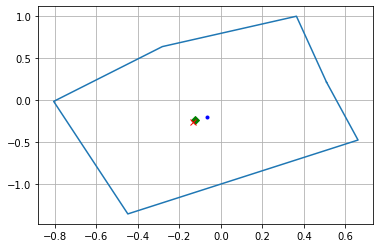

In [50]:
# Generating internal nodes based on grid score

# First try to figure out how to place one node
# 1. Loop through point grid to find the Gridpoint with the lowest score.
#    -> Interpolate the location based on all the neighbours' scores.
#    -> How?: We know that each gridpoint is spaced ~0.136 apart horizontally and ~0.192 diagonally
#             We know that the node should be located in the direction of the neighbours with the lowest scores.
# 2. Find lowest quadrant score by identifying which diagonal neighbour has the lowest score
# 3. Weight each node with (total_score-score)/total_score where total_score is the quadrant's total score
# 4. Sum the x- and y-coords with regards to the weights:
#    -> x1*w1 + x2*w2 + x3*w3 + x4*w4 / 4 , and same for y
#    -> Output should be a nice interpolation of x and y.
              
# Test data
pg = generate_point_grid()
test_point = [(-0.123, -0.234)]
contour = pp.procrustes(pp.create_random_ngon(6))['transformed_contour']
calculate_score(pg, test_point, contour)

# while we havent yet found the target internal node count:
min_grid_point = min([x for i in pg for x in i], key=lambda x: x.score)

# Identify correct quadrant: every two neighbours (starting with the first, is a diagonal neighbour)
lowest_score_diagonal_node = min_grid_point.neighbours[0]
lowest_score_diagonal_node_index = 0
for i in [2, 4, 6]:
    if min_grid_point.neighbours[i].score < lowest_score_diagonal_node.score:
        lowest_score_diagonal_node = min_grid_point.neighbours[i]
        lowest_score_diagonal_node_index = i

# The neighbour indices of each node in the quadrant containing a given diagonal node
quadrants = {
    0: [7, 0, 1],
    2: [1, 2, 3],
    4: [3, 4, 5],
    6: [5, 6, 7],
}

# Construct a list of gridpoints in the quadrant
gridpoint_quadrant = [min_grid_point.neighbours[i] for i in quadrants[lowest_score_diagonal_node_index]]
gridpoint_quadrant.append(min_grid_point)

# Create weights
total_score = sum(point.score**2 for point in gridpoint_quadrant)
weights = np.array([(total_score-point.score**2)/total_score for point in gridpoint_quadrant])
total_weight = sum(weights)

# Interpolate based on weights
interpolated_x = 0
interpolated_y = 0
for i, p in enumerate(gridpoint_quadrant):
    interpolated_x += weights[i]*p.x
    interpolated_y += weights[i]*p.y
interpolated_x /= total_weight
interpolated_y /= total_weight

# *** Outputs ***
# Plot target point (green) and min grid point (red)
plt.plot(min_grid_point.x, min_grid_point.y, 'b.')
plt.plot(test_point[0][0], test_point[0][1], 'gD')
plt.plot(interpolated_x, interpolated_y, 'rx')
pp.plot_polygon(contour)
plt.grid(b=True)

[point.score for point in gridpoint_quadrant], total_score, weights, total_weight, interpolated_x, interpolated_y

In [26]:
# === Creating patches dataset ===
# 1. Read meshed contours to dataframe
df = pd.read_csv('data/6-gon-mesh-with-internal-nodes.csv')

# 2. Separate based on internal nodes added. We choose 2 as it has the highest incidence.
#    -> Remove empty columns with dropna.
#    -> Remove target_edge_length column (experiment).ArithmeticError
df_two_internal = df[df.internal_node_count == 2.0].dropna(axis=1, how='all')
df_two_internal = df_two_internal.drop("target_edge_length", axis=1)

# 3. Different 'target_edge_length's can produce same mesh.
#    -> Since we remove differentiation on target_edge_length, we should also
#    -> remove these duplicates. 
df_two_internal_no_dupes = df_two_internal.drop_duplicates()

dataset = df_two_internal_no_dupes
# patches_to_csv(generate_patch_collection(dataset))


# Neural network 2: predicting internal node positions (or rather: predict grid score)

For now we only train the network on the dataset with:
- 6 edges
- 2 internal nodes
- 100 2x2 patches


In [ ]:
# packages
from tensorflow.keras import layers, metrics
import sklearn.utils

# Parameters
LEARNING_RATE = 1e-4
EPOCHS = 5000
BATCH_SIZE = 512

patches = pd.read_csv('data/patches-dataset.csv')
patches = sklearn.utils.shuffle(patches)

# Split dataset into 70/15/15 training/validation/test
patches_train = patches.sample(frac=0.85, random_state=0)
patches_test = patches.drop(patches_train.index)

# Split dataset into features and labels; last 4 columns 
# (predicted grid scores of a patch) are the labels.
train_features = patches_train.iloc[:, :-4]
train_labels = patches_train.iloc[:, -4:]

test_features = patches_train.iloc[:, :-4]
test_labels = patches_train.iloc[:, -4:]

model = tf.keras.Sequential([
    tf.keras.Input(shape=(20,)),
    layers.BatchNormalization(),

    layers.Dense(16),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(16),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1),
])

model.summary()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              )

history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    )

# Evaluate the model
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

# plot history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()





In [ ]:
# model.save('model/six_edge_two_internal_model')